# Assignment 2
Hvis objektet fortrenger like mye vann som sin egen vekt, vil det ligge i ro.


$$
\begin{aligned}
\\
\frac{\rho_{pipe}}{\rho_{water}} &= 1\\
\\
m_{inside} \approx 0 \implies  \frac{m_{cf}}{m_{water}} &= 1\\
\\
\frac{\pi(D^2-d^2) L \rho_{cf}}{\pi D^2 L \rho_{water}} &= 1\\
\\
\frac{D^2 - d^2}{D^2} &= \frac{\rho_{water}}{\rho_{cf}}\\
\\
\frac{d}{D} &= \sqrt{1 - \frac{\rho_{water}}{\rho_{cf}}}
\end{aligned}
$$

In [51]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

In [52]:
# Constants
MAX_DIAMETER = 25 # mm
RHO_W = 1000 # kg/m^3 
EXTERNAL_PRESSURE = 100 # MPa

# Functions

In [53]:
def get_inner_diameter(D, rho_w, rho_material):
    """ Calculates the inner diameter based on the outer diameter to acchieve neutral buoyancy """
    return np.sqrt(1- (rho_w/rho_material)) * D


def fE_tsaiwu(s,m):
    """ Calculates the Tsai-Wu exposure factor """
    s1,s2,s3,s23,s13,s12=s[0],s[1],s[2],s[3],s[4],s[5]
    XT,YT,ZT,XC,YC,ZC,S12,S13,S23 = m['XT'], m['YT'], m['ZT'], m['XC'], m['YC'], m['ZC'], m['S12'], m['S13'], m['S23']
    f12, f13, f23 = m['f12'], m['f13'], m['f23']
    F1,  F2,  F3  = (1/XT)-(1/XC) , (1/YT)-(1/YC) , (1/ZT)-(1/ZC)
    F11, F22, F33 =     1/(XT*XC) ,     1/(YT*YC) ,     1/(ZT*ZC)
    F44, F55, F66 =    1/(S23**2) ,    1/(S13**2) ,     1/(S12**2)
    F12 = f12*(F11*F22)**0.5
    F13 = f13*(F11*F33)**0.5
    F23 = f23*(F22*F33)**0.5
    a=F11*(s1**2) + F22*(s2**2) + F33*(s3**2)+ 2*(F12*s1*s2 + F13*s1*s3 + F23*s2*s3)+\
    F44*(s23**2) + F55*(s13**2) + F66*(s12**2)
    if a==0:
        return 0
    b=F1*s1 + F2*s2 +F3*s3
    c=-1
    R=(-b+(b**2-4*a*c)**0.5)/(2*a)
    fE=1/R
    return fE


def fE_tsaiwu_const_s3(s1, s2, s3 ,m):
    """ Modified Tsai-Wu exposure factor for constant s3. Simplified to exclude shear stresses """
    XT,YT,ZT,XC,YC,ZC, = m['XT'], m['YT'], m['ZT'], m['XC'], m['YC'], m['ZC']
    f12, f13, f23 = m['f12'], m['f13'], m['f23']
    F1,  F2,  F3  = (1/XT)-(1/XC) , (1/YT)-(1/YC) , (1/ZT)-(1/ZC)
    F11, F22, F33 =     1/(XT*XC) ,     1/(YT*YC) ,     1/(ZT*ZC)
    F12 = f12*(F11*F22)**0.5
    F13 = f13*(F11*F33)**0.5
    F23 = f23*(F22*F33)**0.5
    
    a=F11*(s1**2) + F22*(s2**2) + 2*F12*s1*s2

    if a==0:
        return 0
    b=F1*s1 + F2*s2 + 2* (F13*s1*s3 + F23*s2*s3)
    c=-1 + F33*(s3**2) + F3*s3
    R=(-b+(b**2-4*a*c)**0.5)/(2*a)
    fE=1/R
    return fE


def fE_maxstress(s,m):
    """ Calculates the maximum stress exposure factor """
    # Using local varibles for easier coding and readability..
    s1,s2,s3,s23,s13,s12=s[0],s[1],s[2],s[3],s[4],s[5]
    XT,YT,ZT,XC,YC,ZC,S12,S13,S23 = m['XT'], m['YT'], m['ZT'], m['XC'], m['YC'], m['ZC'], m['S12'], m['S13'], m['S23']
    fE=max(s1/XT,-s1/XC,s2/YT,-s2/YC,s3/ZT,-s3/ZC,abs(s12/S12),abs(s13/S13),abs(s23/S23))
    return fE

def fE_maxstrain(s,m):
    """ Calculates the maximum strain exposure factor """
    s1,s2,s3,s23,s13,s12=s[0],s[1],s[2],s[3],s[4],s[5]
    XT,YT,ZT,XC,YC,ZC,S12,S13,S23 = m['XT'],m['YT'],m['ZT'],m['XC'],m['YC'],m['ZC'],m['S12'],m['S13'],m['S23']
    E1,E2,E3,v12,v13,v23,G12,G13,G23=m['E1'],m['E2'],m['E3'],m['v12'],m['v13'],m['v23'],m['G12'],m['G13'],m['G23']
    e1=   (1/E1)*s1 + (-v12/E1)*s2 + (-v13/E1)*s3
    e2=(-v12/E1)*s1 +    (1/E2)*s2 + (-v23/E2)*s3
    e3=(-v13/E1)*s1 + (-v23/E2)*s2 +    (1/E3)*s3
    e23,e13,e12 = s23/G23, s13/G13, s12/G12
    f=max( e1/(XT/E1),-e1/(XC/E1),e2/(YT/E2),-e2/(YC/E2),e3/(ZT/E3),-e3/(ZC/E3),
           abs(e12/(S12/G12)),abs(e13/(S13/G13)),abs(e23/(S23/G23)) )
    return f


def fE_hashin(s,m):
    """ Hashin exposure factor """
    s1,s2,s3,s23,s13,s12=s[0],s[1],s[2],s[3],s[4],s[5]
    XT,YT,ZT,XC,YC,ZC,S12,S13,S23 = m['XT'], m['YT'], m['ZT'], m['XC'], m['YC'], m['ZC'], m['S12'], m['S13'], m['S23']
    if s1>0:
        R = ( 1/( (s1/XT)**2 + (1/S12**2)*(s12**2 + s13**2) ) )**0.5
        fE_FF=1/R
    if s1<=0:
        fE_FF=-s1/XC
    if (s2+s3)>=0:
        temp=( (1/YT**2)*(s2+s3)**2+(1/S23**2)*(s23**2-s2*s3)+(1/S12**2)*(s12**2+s13**2) )
        if temp==0:
            fE_IFF = 0
        else:
            R = (1/temp)**0.5
            fE_IFF = 1/R
    if (s2+s3)<0:
        b = (1/YC)*((YC/(2*S23))**2-1)*(s2+s3)
        a = (1/(4*S23**2))*(s2+s3)**2+(1/S23**2)*(s23**2-s2*s3)+(1/S12**2)*(s12**2+s13**2)
        if a==0:
            fE_IFF = 0.0
        else:
            c=-1
            R=(-b+(b**2-4*a*c)**0.5)/(2*a)
            fE_IFF = 1/R
    return fE_FF, fE_IFF

def fE_hashin_const_s3(s1,s2,s3,m):
    """ Modified Hashin exposure factor for constant s3. Excludes shear stresses and (s2 + s3) >= 0 """
    XT,YT,ZT,XC,YC,ZC,S12,S13,S23 = m['XT'], m['YT'], m['ZT'], m['XC'], m['YC'], m['ZC'], m['S12'], m['S13'], m['S23']
    
    if s1>0:
        R = XT/s1
        fE_FF=1/R

    if s1<=0:
        fE_FF=-s1/XC

    if (s2+s3)<0:
        a = 1/(4*S23**2) * s2**2
        b = 1/(4*S23**2) * 2*s2*s3 - 1 / S23 * s2 * s3 + 1/YC * (YC**2/(4*S23**2) - 1) * s2
        if a==0:
            fE_IFF = 0.0
        else:
            c= 1/(4*S23**2) * s3**2 + 1/YC * (YC**2/(4*S23**2) - 1) * s3 -1
            R=(-b+(b**2-4*a*c)**0.5)/(2*a)
            fE_IFF = 1/R
    return fE_FF, fE_IFF


# ------------ PLOTS ------------

def plot_tsaiwu_various_s3(material, sigma_1, sigma_2, sigma_3, pos):
    """plots the Tsai-Wu failure envelope for various s3"""

    num_iterations = len(sigma_1)
    
    fig,ax = plt.subplots(figsize=(10,7))
    plt.title("Tsai-Wu Failure Envelope", fontsize=20)

    # Lag en fargegradient basert på antall iterasjoner
    colors = [plt.cm.turbo  (i / (num_iterations - 1)) for i in range(num_iterations)]

    # Making axes through the origo:
    ax.plot((0,),(0,),'+',color='black',markersize=50)

    for i in range(num_iterations): # itterer over alle punkter
        # if (i%2 == 0):
        #     continue

        color = colors[i % len(colors)]
        s3i = sigma_3[i]
        # empty list of normal stresses in the 1-2 plane:
        s1_TW,s2_TW=[],[]  # tsai-wu

        for a in np.linspace(0, 2*np.pi, 3600):
            s1i=np.cos(a)
            s2i=np.sin(a)

            feTW=fE_tsaiwu_const_s3(s1i,s2i,s3i,material)

            # then scaling by the load-proportionality ratio (1/fE):
            s1_TW.append(s1i/feTW)
            s2_TW.append(s2i/feTW)

        current_r = (MAX_DIAMETER - pos[i])/2
        # Plot failure envelope
        ax.plot(s1_TW, s2_TW, label=f"σ₃ = {s3i:.1f}, r = {current_r:.2f}", linewidth=1, color=color)

        # ---- Plot actual stress ----
        ax.plot(sigma_1[i], sigma_2[i], color=color, marker='o', markersize=8)

    # Add text for positions
    ax.text((sigma_1[0] + 100), sigma_2[0], "Outer surface", fontsize=10, color=colors[0])
    ax.text((sigma_1[-1] + 100), sigma_2[-1], "Inner surface", fontsize=10, color=colors[-1])

    ax.legend()
    ax.set_xlabel(r'$\sigma_1$ (fiber direction)',fontsize=14)
    ax.set_ylabel(r'$\sigma_2$',fontsize=14)
    ax.grid(True)
    plt.tight_layout()


def plot_hashin_various_s3(material, sigma_1, sigma_2, sigma_3, pos): # TODO: Incomplete function (not in use)
    
    num_iterations = len(pos)
    
    fig,ax = plt.subplots(figsize=(8,4))
    # ax.set_xlim(-3000, 2000)
    # ax.set_ylim(100, -400)

    # Lag en fargegradient basert på antall iterasjoner
    colors = [plt.cm.turbo  (i / (num_iterations - 1)) for i in range(num_iterations)]

    # Making axes through the origo:
    ax.plot((0,),(0,),'+',color='black',markersize=50)

    for i in range(num_iterations): # itterer over alle punkter
      
        color = colors[i % len(colors)]
        s3i = sigma_3[i]
        # empty list of normal stresses in the 1-2 plane:
        s1_Hashin,s2_Hashin=[],[]

        for a in np.linspace(0, 2*np.pi, 3600):
            s1i=np.cos(a)
            s2i=np.sin(a)

            fE_FF, fE_IFF =fE_hashin_const_s3(s1i,s2i,s3i,material)

            # then scaling by the load-proportionality ratio (1/fE):
            s1_Hashin.append(s1i/fE_IFF)
            s2_Hashin.append(s2i/fE_IFF)

        # Plot failure envelope
        ax.plot(s1_Hashin,s2_Hashin,label=f"S3 = {s3i:.1f}, r = {(MAX_DIAMETER - pos[i]):.2f}",linewidth=1, color=color)
        
        # ---- Plot actual stress ----
        ax.plot(sigma_1[i], sigma_2[i], color=color, marker='o')

    # Add text for positions
    ax.text(sigma_1[0], sigma_2[0], "Outer surface", fontsize=10, color=colors[0])
    ax.text(sigma_1[-1], sigma_2[-1], "Inner surface", fontsize=10, color=colors[-1])

    # ax.legend()
    ax.set_xlabel(r'$\sigma_1$ (fiber direction)',fontsize=14)
    ax.set_ylabel(r'$\sigma_2$',fontsize=14)
    ax.grid(True)
    plt.tight_layout()


def plot_max_stress(material, sigma_1, sigma_2, sigma_3, pos, label_start="", label_end=""):
    """Plots the failure envelope for max stress"""
    fig,ax = plt.subplots(figsize=(8,4))

    # Making axes through the origo:
    ax.plot((0,),(0,),'+',color='black',markersize=50)
    plt.title("Max-Stress Failure Envelope", fontsize=20)
    
    # empty list of normal stresses in the 1-2 plane:
    s1_MS,s2_MS=[],[]  
    s1_ME,s2_ME=[],[]

    for a in np.linspace(0, 2*np.pi, 3600):
        s1i=np.cos(a)
        s2i=np.sin(a)

        fe_MS = fE_maxstress((s1i,s2i,0,0,0,0), material)
        fe_ME = fE_maxstrain((s1i,s2i,0,0,0,0), material)

        # then scaling by the load-proportionality ratio (1/fE):
        s1_MS.append(s1i/fe_MS)
        s2_MS.append(s2i/fe_MS)

        s1_ME.append(s1i/fe_ME)
        s2_ME.append(s2i/fe_ME)

    # Plot failure envelope
    ax.plot(s1_MS,s2_MS,color="black",linewidth=1, ls="--", label="Max stress")
    # ax.plot(s1_ME,s2_ME,color="m",linewidth=1, ls="--", label="Max strain")
        
    # ---- Plot actual stresses ----

    # Plot points
    ax.plot(sigma_1, sigma_2, color='red', label=r"$\sigma_2$")
    ax.plot(sigma_1, sigma_3, color='blue', label=r"$\sigma_3$")



    # Add text for min and max radial pos
    ax.text(sigma_1[0], sigma_3[0], label_start, fontsize=10)
    ax.text(sigma_1[-1], sigma_3[-1], label_end, fontsize=10)


    ax.legend(loc='upper right')
    ax.set_xlabel(r'$\sigma_1$',fontsize=14)
    ax.set_ylabel(r'$\sigma_2$ / $\sigma_3$',fontsize=14)
    ax.grid(True)
    plt.tight_layout()

Hashin and Tsai-Wu were modified to set sigma 3 to constant. Example using Tsai-Wu:

$$
\begin{aligned}
a &= F_{11} \sigma_1^2 + F_{22} \sigma_2^2 + 2F_{12} \sigma_1 \sigma_2 \\
b &= F_1 \sigma_1 + F_2 \sigma_2 + 2 (F_{13} \sigma_1 \sigma_3 + F_{23} \sigma_2 \sigma_3) \\
c &= -1 + F_{33} \sigma_3^2 + F_3 \sigma_3 \\
R &= \frac{-b + \sqrt{b^2 - 4ac}}{2a} \\
f_E &= \frac{1}{R}
\end{aligned}
$$


# Material

In [54]:
Carbon_EpoxyA = {
    "name": "Carbon/Epoxy(a)", 
    "units": "MPa-mm-Mg", "type": "UD", "fiber": "Carbon",
    "Vf": 0.55, 
    "rho": 1600, # kg/m^3
    "description": "Typical low modulus carbon/Epoxy from TMM4175",  
    "E1": 130000, 
    "E2": 10000, 
    "E3": 10000, 
    "v12": 0.28, "v13": 0.28, "v23": 0.5, 
    "G12": 4500, "G13": 4500, "G23": 3500, 
    "a1": -0.5e-06, "a2": 3.0e-05, "a3": 3.0e-05, 
    "XT": 1800, "YT": 40, "ZT": 40,
    "XC": 1200, "YC": 180, "ZC": 180,
    "S12": 70, "S13": 70, "S23": 40,
    "f12":-0.5, "f13":-0.5, "f23":-0.5
}

# Pipe Dimensions

In [55]:
D_end = MAX_DIAMETER
num_layers = 2

d = get_inner_diameter(D_end, RHO_W, rho_material=Carbon_EpoxyA['rho'])

ri = d/2.0
ro = D_end/2.0
t = ro - ri
h = t / num_layers

print(f"Inner radius: {ri:.5f} mm\nOuter radius: {ro:.5f} mm\nThickness: {t:.5f} mm\nLaminate thickness: {h:.5f} mm")


Inner radius: 7.65466 mm
Outer radius: 12.50000 mm
Thickness: 4.84534 mm
Laminate thickness: 2.42267 mm


## Calculation for Point Force in Abaqus (longitudinal pressure)

In [56]:
A = 0.5 * np.pi * ro**2
F = A * EXTERNAL_PRESSURE
F

24543.692606170258

# Results From Abaqus

In [57]:
# Position (from r0 to ri)
pos = [
    0,
    0.482111,
    0.96419,
    1.44623,
    1.92824,
    2.41019,
    2.41019,
    2.89234,
    3.3751,
    3.85853,
    4.34273,
    4.82781,
]

S11 = [
    -244.178,
    -244.178,
    -244.178,
    -244.178,
    -244.178,
    -244.178,
    -440.439,
    -432.477,
    -420.548,
    -417.767,
    -427.01,
    -435.068,
]

S22 = [
    -89.8445,
    -89.6269,
    -89.1631,
    -88.6367,
    -88.0361,
    -87.7157,
    -71.3565,
    -66.8048,
    -57.4717,
    -47.5171,
    -36.539,
    -30.734,
]

S33 = [
    -100.201,
    -100.418,
    -100.882,
    -101.408,
    -102.009,
    -102.33,
    -94.3609,
    -85.6005,
    -67.4482,
    -47.6588,
    -25.3043,
    -13.3474,
]

# Max Stress

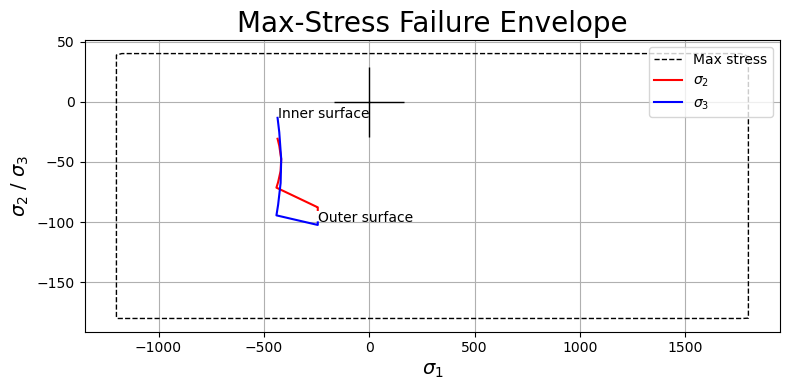

In [58]:
plot_max_stress(Carbon_EpoxyA, sigma_1=S11, sigma_2=S22, sigma_3=S33, pos=pos, label_start="Outer surface", label_end="Inner surface")

### Print and plot the exposure factors

Maximum stress criterion
  Position      Exposure factor
----------------------------------------
     12.50              0.55667
     12.26              0.55788
     12.02              0.56046
     11.78              0.56338
     11.54              0.56672
     11.29              0.56850
     11.29              0.52423
     11.05              0.47556
     10.81              0.37471
     10.57              0.34814
     10.33              0.35584
     10.09              0.36256


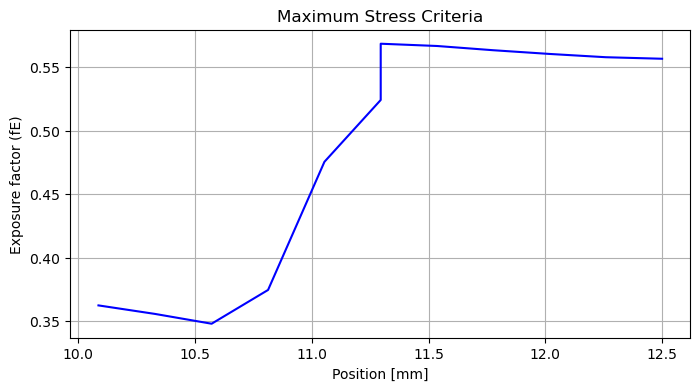

In [59]:
print("Maximum stress criterion")
print(f"{'Position':>10} {'Exposure factor':>20}")
print("-" * 40)

fig,ax = plt.subplots(figsize=(8,4))

fE_list, pos_list = [], []

for i in range(len(pos)):
    r_pos = (MAX_DIAMETER - pos[i]) / 2
    s1i, s2i, s3i = S11[i], S22[i], S33[i]

    fe = fE_maxstress((s1i, s2i, s3i, 0, 0, 0), Carbon_EpoxyA)
    fE_list.append(fe)
    pos_list.append(r_pos)

    print(f"{r_pos:10.2f} {fe:20.5f}")

plt.plot(pos_list, fE_list, label="Fiber Fracture", color="b")
plt.xlabel("Position [mm]")
plt.ylabel("Exposure factor (fE)")
plt.grid()
plt.title("Maximum Stress Criteria")
plt.show()

# Tsai Wu

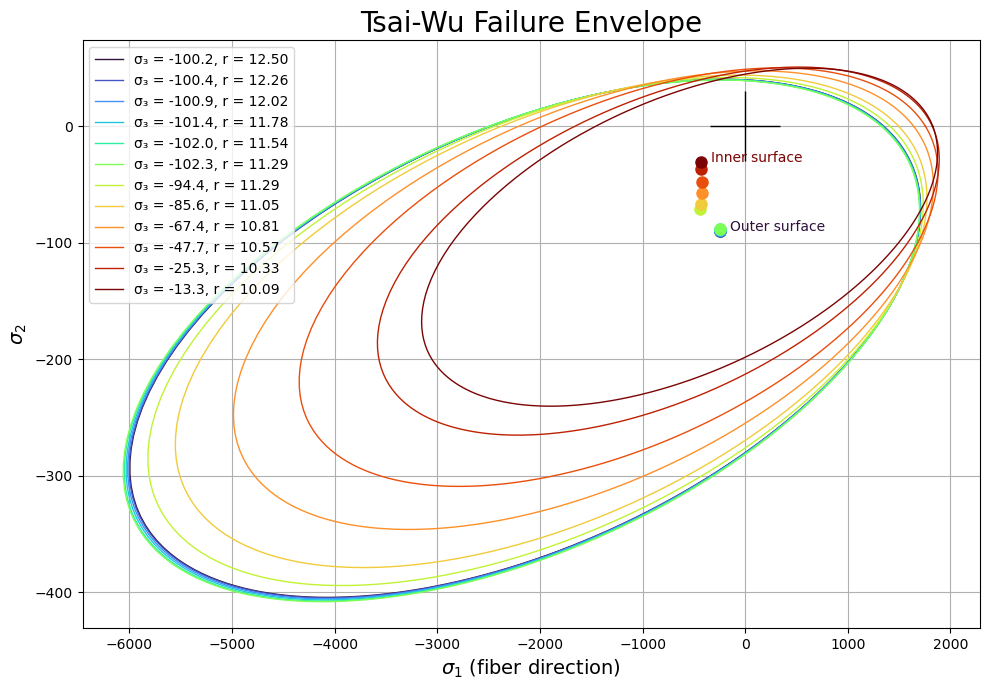

In [60]:
# Get D and d
D = MAX_DIAMETER
d = get_inner_diameter(D, RHO_W, rho_material=Carbon_EpoxyA['rho'])

plot_tsaiwu_various_s3(Carbon_EpoxyA, sigma_1=S11, sigma_2=S22, sigma_3=S33, pos=pos)

### Print and plot the exposure factors

Tsai-Wu criterion
  Position      Exposure factor
----------------------------------------
     12.50              0.27393
     12.26              0.27299
     12.02              0.27099
     11.78              0.26873
     11.54              0.26616
     11.29              0.26479
     11.29              0.19188
     11.05              0.18447
     10.81              0.16913
     10.57              0.15375
     10.33              0.14354
     10.09              0.14659


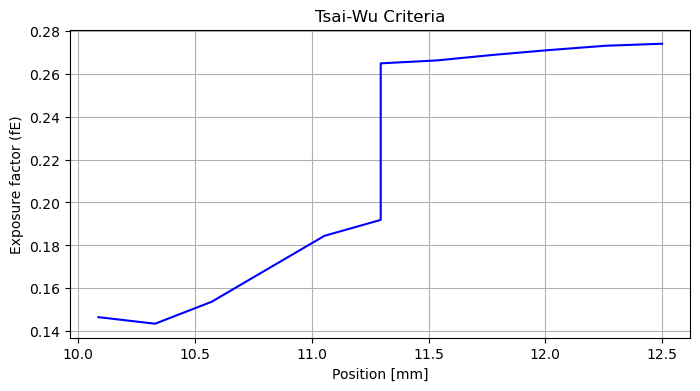

In [61]:
print("Tsai-Wu criterion")
print(f"{'Position':>10} {'Exposure factor':>20}")
print("-" * 40)

fig,ax = plt.subplots(figsize=(8,4))

fE_list, pos_list = [], []

for i in range(len(pos)):
    r_pos = (MAX_DIAMETER - pos[i]) / 2
    s1i, s2i, s3i = S11[i], S22[i], S33[i]

    fe = fE_tsaiwu_const_s3(s1i, s2i, s3i, Carbon_EpoxyA)
    fE_list.append(fe)
    pos_list.append(r_pos)

    print(f"{r_pos:10.2f} {fe:20.5f}")

plt.plot(pos_list, fE_list, label="Fiber Fracture", color="b")
plt.xlabel("Position [mm]")
plt.ylabel("Exposure factor (fE)")
plt.grid()
plt.title("Tsai-Wu Criteria")
plt.show()

# Hashin

### Print and plot the exposure factors

Hashin Criteria
  Position       Fiber Fracture      Inter Fiber Fracture
------------------------------------------------------------
     12.50              0.20348                   0.00562
     12.26              0.20348                   0.00560
     12.02              0.20348                   0.00554
     11.78              0.20348                   0.00548
     11.54              0.20348                   0.00541
     11.29              0.20348                   0.00538
     11.29              0.36703                   0.00474
     11.05              0.36040                   0.00489
     10.81              0.35046                   0.00532
     10.57              0.34814                   0.00619
     10.33              0.35584                   0.00882
     10.09              0.36256                   0.01362


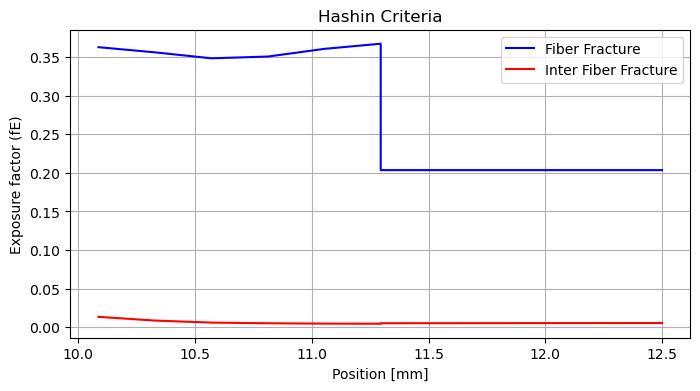

In [62]:
print("Hashin Criteria")
print(f"{'Position':>10} {'Fiber Fracture':>20} {'Inter Fiber Fracture':>25}")
print("-" * 60)

fig,ax = plt.subplots(figsize=(8,4))

fE_FF_list, fE_IFF_list, pos_list = [], [], []

for i in range(len(pos)):
    r_pos = (MAX_DIAMETER - pos[i]) / 2
    s1i, s2i, s3i = S11[i], S22[i], S33[i]

    fE_FF, fE_IFF = fE_hashin_const_s3(s1i, s2i, s3i, Carbon_EpoxyA)
    fE_FF_list.append(fE_FF)
    fE_IFF_list.append(fE_IFF)
    pos_list.append(r_pos)

    print(f"{r_pos:10.2f} {fE_FF:20.5f} {fE_IFF:25.5f}")

plt.plot(pos_list, fE_FF_list, label="Fiber Fracture", color="b")
plt.plot(pos_list, fE_IFF_list, label="Inter Fiber Fracture", color="r")
plt.legend()
plt.xlabel("Position [mm]")
plt.ylabel("Exposure factor (fE)")
plt.grid()
plt.title("Hashin Criteria")
plt.show()

# Bucling calculations

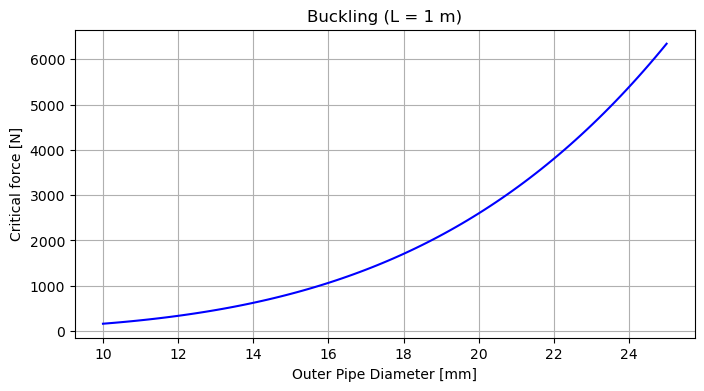

In [63]:
# Compare different outer diameters and buckling
Outer_diamters = np.linspace(MAX_DIAMETER, MAX_DIAMETER*0.4, 100)

buckling_force = []

for D_outer in Outer_diamters:

    ro = D_outer / 2.0
    d = get_inner_diameter(D_outer, RHO_W, rho_material=Carbon_EpoxyA['rho'])
    ri = d / 2.0

    I = np.pi * (ro**4 - ri**4) / 4.0

    # E modulus from Abaqus
    E_eff = 39E3 # GPa

    # Calculate critical buckling force
    L = 1000 # mm
    P = np.pi**2 * E_eff * I / (L**2)
    buckling_force.append(P)

fig,ax = plt.subplots(figsize=(8,4))

plt.plot(Outer_diamters, buckling_force, color="b")
plt.xlabel("Outer Pipe Diameter [mm]")
plt.ylabel("Critical force [N]")
plt.grid()
plt.title("Buckling (L = 1 m)")
plt.show()
